# Project 2 - Source coding, data compression and channel coding

The goal of this second project is to apply some of the principles seen in the lectures about source coding, data compression and channel coding. We ask you to write a brief report (pdf format) collecting your answers to the different questions. All codes must be written in Python inside this Jupyter. Note that you can not change the content of locked cells or import any extra Python library than the ones already imported (numpy).

## Implementation

In this project, you will need to use implement source coding algorithms to answer several questions. Therefore, in this first part, you are asked to write several functions that implement two of the  algorithms seen in the theoretical lectures and one new algorithm described in the project statement. Remember that you need to fill in this Jupyter Notebook to answer these questions. Pay particular attention to the required input and output format of each function.

In [22]:
# [Locked Cell] You can not import any extra Python library in this Notebook.
import numpy as np

### Question 1
Implement a function that returns a binary Huffman code for a given probability distribution. Give the main steps of your implementation. Verify your code on Exercise 7 of the second exercise session (TP2), and report the output of your code for this example. Explain how to extend your function to generate a Huffman code of any (output) alphabet size. 


In [23]:
class Node:
    def __init__(self, symbol, prob):
        self.symbol = symbol
        self.prob = prob
        self.left = None
        self.right = None
        self.code = ''

def Huffman_code(probability_dict):
    """
    Create the Huffman code for given probabilities.
    
    Arguments:
    probability_dict: A dictionary where keys are symbols (characters or strings)
                      and values are the probability of the symbol as a float or double.
    
    Returns:
    codewords: A dictionary with the name and the corresponding codeword.
               Keys are symbols (characters or strings) and values are associated
               codeword as a character or a string.
    """
    nodes = [Node(symbol, prob) for symbol, prob in probability_dict.items()]
    while len(nodes) > 1:

        nodes.sort(key=lambda node: node.prob)
        
        # Nodes with fewer probs
        left = nodes.pop(0)
        right = nodes.pop(0)

        # Combine
        new_node = Node(None, left.prob + right.prob)
        new_node.left = left
        new_node.right = right

        nodes.append(new_node)

    # Recursive function to assign codes to leaves
    def assign_codes(node, prefix=''):
        if node.symbol is not None:
            return {node.symbol: prefix}
        else:
            codes = {}
            codes.update(assign_codes(node.left, prefix + '0'))
            codes.update(assign_codes(node.right, prefix + '1'))
            return codes

    root = nodes[0]
    codeword_dict = assign_codes(root)

    return codeword_dict

probability_dict = {"A": 0.2, "B": 0.2, "C": 0.2, "D": 0.2, "E": 0.2} # example?
Huffman_code(probability_dict)


{'C': '00', 'D': '01', 'E': '10', 'A': '110', 'B': '111'}

### Question 2

Given a sequence of symbols, implement a function that returns a dictionary and the encoded sequence using the on-line Lempel-Ziv algorithm (see State of the art in data compression, slide 50/53). Reproduce and report the example given in the course. 

In [24]:
def LZ_Online(sequence):
    """
    The on-line Lempel-Ziv algorithm given a sequence of symbols.
    
    Arguments:
    - sequence: Sequence of symbols in the string format

    Return:
    - dictionary: the computed dictionary in the form:
      keys: symbol as character or string
      values: associated codeword as a tuple (integer) and a binarized address with one appended symbol (character or string)
      Example: {'0': (0, ''), '1': (1, '0'), '10': (2, '01'), '00': (3, '010')}
    
    - encoded_sequence: the encoded sequence in the string format
    """
    dictionary = {'': (0, '0')}
    encoded_sequence = ""
    w = ""
    # The first entry is special, handle it separately
    if sequence[0] == '1':
        dictionary['1'] = (1, '1')
        encoded_sequence += "1"
        index = 2  
    else:
        dictionary['0'] = (1, '0')
        encoded_sequence += "0"
        index = 2 
        
    for c in sequence[1:]:
        wc = w + c
        if wc not in dictionary:
            address_bits = int(np.ceil(np.log2(len(dictionary))))
            prefix = format(dictionary[w][0], '0{}b'.format(address_bits)) 
            encoded_sequence += prefix
            
            bin_address = format(index, '0{}b'.format(address_bits))
            dictionary[wc] = (index, bin_address) 
            
            index += 1
            w = ""
        else:
            w = wc
            
    # Encode the last phrase if it's not empty
    if w:
        address_bits = int(np.ceil(np.log2(max(len(dictionary), 1))))
        prefix = format(dictionary[w][0], '0{}b'.format(address_bits))
        encoded_sequence += prefix
    
    return dictionary, encoded_sequence

sequence = "1122/121/121_221"
dictionary, encoded_sequence = LZ_Online(sequence)
print(f'dictionary: {dictionary}')
print(f'encoded sequence: {encoded_sequence}')


dictionary: {'': (0, '0'), '1': (1, '1'), '12': (2, '10'), '2': (3, '11'), '/': (4, '100'), '121': (5, '101'), '/1': (6, '110'), '21': (7, '111'), '_': (8, '1000'), '22': (9, '1001')}
encoded sequence: 11000001010001100000110001


### Question 4

Implement a function that returns the encoded sequence using the LZ77 algorithm as described by the algorithm below given an input string and a sliding window size l. Reproduce the example given in Figure 2 with window_size=7.

In [25]:
def LZ77(sequence, window_size=7):
    """
    The Lempel-Ziv 77 algorithm given a sequence of symbols and the sliding window size.
    
    Arguments:
    ----------
    - sequence : Sequence of symbols in the string format
    - window_size : sliding window size as an integer
    
    Return:
    -------
    - encoded_sequence : the encoded sequence in the string format
    """
    encoded_sequence = []
    cursor = 0

    while cursor < len(sequence):
        # Look-ahead buffer
        buffer = sequence[cursor:]
        window = sequence[max(0, cursor-window_size):cursor]

        p = 0
        d = 0
        c = ''
        
        for length in range(1, len(buffer)+1):
            prefix = buffer[:length]
            position = window.rfind(prefix)
            if  position>= 0:
                d = len(window) - position
                p = length
                c = buffer[length] if length < len(buffer) else ''
            else:
                break
             
        # If no match found, just take the first character of the buffer
        if p == 0 and len(buffer) > 0:
            c = buffer[0]
        
        encoded_sequence.append((d, p, c))
        shift = p + 1 if p > 0 else 1
        cursor += shift
    
    encoded_sequence_str = ''.join(['{}{}{}'.format(d, p, c) for d, p, c in encoded_sequence])
    
    return encoded_sequence_str

test_sequence = "abracadabrad"
test_window_size = 7
encoded_result = LZ77(test_sequence, test_window_size)
print(f'Encoded result: {encoded_result}')

Encoded result: 00a00b00r31c21d74d


In [26]:
# [Locked Cell] Evaluation of your functions by the examiner. 
# You don't have access to the evaluation, this will be done by the examiner.
# Therefore, this cell will return nothing for the students.
import os
if os.path.isfile("private_evaluation.py"):
    from private_evaluation import unit_tests
    unit_tests(Huffman_code, LZ_online, LZ77)

## Source coding and reversible (lossless) data compression


### Question 5

Estimate the marginal probability distribution of all symbols (1,2,_,/) from the given
wigwag text, and determine the corresponding binary Huffman code and the encoded
wigwag text. Give the total length of the encoded wigwag text and the compression
rate.

In [27]:
with open("wigwag.txt") as file:
    wigwag = file.readline()

wigwag_probas = {c: wigwag.count(c)/len(wigwag) for c in set(wigwag)}

print(wigwag_probas)
huffman = Huffman_code(wigwag_probas)
print(huffman)
encoded = "".join([huffman[w] for w in wigwag])
print(f"{len(encoded)=}")
print(f"Compression rate : {len(wigwag)*np.log2(len(set(wigwag)))/len(encoded)}")

{'_': 0.21699897098530355, '2': 0.3918435194061618, '1': 0.32239821989252515, '/': 0.06875928971600953}
{'2': '0', '/': '100', '_': '101', '1': '11'}
len(encoded)=215340
Compression rate : 1.0560137457044674


### Question 6

Give the expected average length for your Huffman code. Compare this value with
(a) the empirical average length, and (b) theoretical bound(s). Justify.

In [28]:
expected_average_length = sum(prob * len(huffman[symbol]) for symbol, prob in wigwag_probas.items())

empirical_average_length = len(encoded) / len(wigwag)

entropy = sum(prob * np.log2(prob) for prob in wigwag_probas.values() if prob != 0) * -1

print(f"{expected_average_length=}")
print(f"{empirical_average_length=}")
print(f"{entropy=}")

# The expected average length and the empirical are nearly the same (and should even be the same, the difference is due to the rounding of numbers), because the probabilities for the huffman code are computed using only the empirical data also used to compute the empirical average length;
# We can also see that the entropy is lower (which is coherent because it is the minimum theritical bound), the maximum bound is the infinity because you can produce a prefix-free, uniquely decodable code and append a symbol to it infinetely to preserve the properties, so the length can always be equal to length + 1.


expected_average_length=1.8939147412951511
empirical_average_length=1.8939147412951514
entropy=1.8000258489373766


### Question 7

Plot the evolution of the empirical average length of the encoded wigwag using your
Huffman code for increasing input text lengths.

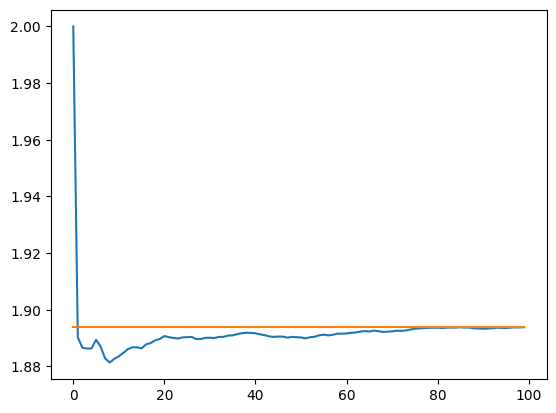

In [29]:
import matplotlib.pyplot as plt

empirical_average_increasing_length = [len("".join([huffman[w] for w in wigwag[:i+1]])) / len(wigwag[:i+1]) for i in range(1, len(wigwag), len(wigwag)//100)]
encoded_increasing_length = [expected_average_length for _ in range(1, len(wigwag), len(wigwag)//100)]
plt.plot(empirical_average_increasing_length)
plt.plot(encoded_increasing_length)
plt.show()

### Question 8

Encode the wigwag code using the on-line Lempel-Ziv algorithm. Give the total
length of the encoded code and the compression rate.

In [30]:
def My_LZ_Online(sequence):
    """
    The on-line Lempel-Ziv algorithm given a sequence of symbols.
    
    Arguments:
    - sequence: Sequence of symbols in the string format

    Return:
    - dictionary: the computed dictionary in the form:
      keys: symbol as character or string
      values: associated codeword as a tuple (integer) and a binarized address with one appended symbol (character or string)
      Example: {'0': (0, ''), '1': (1, '0'), '10': (2, '01'), '00': (3, '010')}
    
    - encoded_sequence: the encoded sequence in the string format with only 0 and 1
    """
    dictionary = {'': (0, '0')}
    encoded_sequence_list = []
    w = ""
    # The first entry is special, handle it separately
    dictionary[sequence[0]] = (1, sequence[0])
    encoded_sequence_list.append(['', sequence[0]])
    index = 2 
    for c in sequence[1:]:
        wc = w + c
        if wc not in dictionary:
            address_bits = int(np.ceil(np.log2(len(dictionary))))
            prefix = format(dictionary[w][0], '0{}b'.format(address_bits)) 
            encoded_sequence_list.append([str(prefix), c])
            
            bin_address = format(index, '0{}b'.format(address_bits))
            dictionary[wc] = (index, bin_address) 
            
            index += 1
            w = ""
        else:
            w = wc
            
    # Encode the last phrase if it's not empty
    if w:
        address_bits = int(np.ceil(np.log2(max(len(dictionary), 1))))
        prefix = format(dictionary[w][0], '0{}b'.format(address_bits))
        encoded_sequence_list.append([prefix, ''])
    
    encoded_letter = {letter : "0"*int(np.ceil(np.log2(len(set(sequence))+1))-len(bin(i+1)[2:])) + bin(i+1)[2:] for i, letter in enumerate(set(sequence))}
    encoded_letter[''] =  "0"*int(np.ceil(np.log2(len(set(sequence))+1)))
    encoded_sequence = ",".join(["0"*(address_bits-len(e[0])) + e[0] + encoded_letter[e[1]] for e in encoded_sequence_list])
    
    return dictionary, encoded_sequence

# sequence = "Hello World"
# dictionary, encoded_sequence = My_LZ_Online(sequence)
# print("Dictionary:", dictionary)
# print("Encoded sequence:", encoded_sequence)

In [31]:
dictionary, encoded = My_LZ_Online(wigwag)

encoded = "".join(encoded.split(","))
# print(f"{encoded=}")
print(f"{len(encoded)=}")
compression_rate = len(wigwag)*np.log2(len(set(wigwag))) / len(encoded)
print(f"{compression_rate}")


len(encoded)=204901
1.1098140077403233


### Question 9

Encode the wigwag code using the LZ77 algorithm with window_size=7. Give the
total length of the encoded text and the compression rate.

In [32]:
def My_LZ77(sequence, window_size=7):
    """
    The Lempel-Ziv 77 algorithm given a sequence of symbols and the sliding window size.
    
    Arguments:
    ----------
    - sequence : Sequence of symbols in the string format
    - window_size : sliding window size as an integer
    
    Return:
    -------
    - encoded_sequence : the encoded sequence in the string format
    """
    encoded_sequence = []
    cursor = 0

    while cursor < len(sequence):
        # Look-ahead buffer
        buffer = sequence[cursor:]
        window = sequence[max(0, cursor-window_size):cursor]

        p = 0
        d = 0
        c = ''
        
        for length in range(1, len(buffer)+1):
            prefix = buffer[:length]
            position = window.rfind(prefix)
            if  position>= 0:
                d = len(window) - position
                p = length
                c = buffer[length] if length < len(buffer) else ''
            else:
                break
             
        # If no match found, just take the first character of the buffer
        if p == 0 and len(buffer) > 0:
            c = buffer[0]
        
        encoded_sequence.append((d, p, c))
        shift = p + 1 if p > 0 else 1
        cursor += shift
    
    letter_bits = int(np.ceil(np.log2(len(set(sequence))+1)))
    encoded_letter = {letter : "0"*(letter_bits-len(bin(i+1)[2:])) + bin(i+1)[2:] for i, letter in enumerate(set(sequence))}
    encoded_letter[''] =  "0"*letter_bits

    address_bits = int(np.ceil(np.log2(window_size+1)))
    return ",".join(["0"*(address_bits-len(bin(d)[2:])) + bin(d)[2:] + "0"*(address_bits-len(bin(p)[2:])) + bin(p)[2:] + encoded_letter[c] for d, p, c in encoded_sequence])

# test_sequence = "abracadabrad"
# test_window_size = 7
# encoded_result = LZ77(test_sequence, test_window_size)
# print(f'Encoded result: {encoded_result}')

In [33]:
encoded = "".join(My_LZ77(wigwag).split(","))
print(f"{encoded=}")
print(f"{len(encoded)=}")
compression_rate = len(wigwag)*np.log2(len(set(wigwag))) / len(encoded)
print(f"{compression_rate}")

encoded='0000000100000000010000000110110010101000111001110110110000000010110110100110010111000010110110110011010110100010010110010011000100010100010010010110110101000101001000110010110110110010010100100010011010100011110100010100010100010011001110100110000000011110100111000010111000010011110100010100010110010011001110110110010010011100100100000001001100010100100010010110110101001000100010011001100010111000010110000000010100100101000100100010011000110110110110010110000000010110100111000010111100110101100100101011000110110100100110010101001000110100011001100100110110010101000010100110111000000000111100110110100100110110010101010100101010100100010011000110100011010110010000000110110010101000111000110100010110010110110010100010010100000001000100010111111000110000001000110100100000000010110010111000110100010010111011010011010100011100100110000001001100100110110010101000110010110010110010011001100010110100010010110110100000001000100010100010010111110100110110110111000100011000010100010011000

### Question 10

Famous data compression algorithms combine the LZ77 algorithm and the Huffman
algorithm. Explain two ways of combining those algorithms and discuss the interest
of the possible combinations.

There is two possible combinations. First perform the Huffman algorithm then the LZ77 algorithm or first the LZ77 then the huffman algorithm. 

**LZ77 followed by Huffman Encoding:** In this approach, the input data is first processed using the LZ77 algorithm to identify repeated substrings. The LZ77 algorithm replaces repeated substrings with references to their previous occurrences, effectively reducing redundancy in the data. This process produces a sequence of literal symbols and references.
After applying LZ77, the resulting sequence is then encoded using the Huffman algorithm. Huffman encoding assigns shorter codes to more frequent symbols and longer codes to less frequent symbols, further reducing the overall size of the data.
This combination leverages the strengths of both algorithms: LZ77 reduces redundancy by finding repeated substrings, and Huffman encoding efficiently represents the resulting symbols.

**Huffman Encoding followed by LZ77:** In this approach, the input data is first encoded using the Huffman algorithm to generate variable-length codes for each symbol based on their frequencies in the input data. This step reduces the overall size of the data by assigning shorter codes to more frequent symbols.
After Huffman encoding, the resulting compressed data is processed using the LZ77 algorithm. LZ77 searches for repeated substrings in the compressed data and replaces them with references, further reducing redundancy and achieving additional compression.
While this approach may seem less intuitive, it can still be effective, especially when the Huffman-encoded data contains repeated patterns that LZ77 can exploit for additional compression.

### Question 11

Encode the wigwag using one of the combinations of LZ77 and Huffman algorithms
you proposed in the previous question. Give the total length of the encoded wigwag
text and the compression rate.

In [13]:
def Huffman_then_LZ77(sequence):
    """
    Perform the huffman algorithm then the LZ77 algorithm given a sequence of symbols.
    
    Arguments:
    - sequence: Sequence of symbols in the string format

    Return:
    - encoded_sequence: the encoded sequence in the string format
    """
    sequence_probas = {c: sequence.count(c)/len(sequence) for c in set(sequence)}
    codewords = Huffman_code(sequence_probas)
    encoded = "".join([codewords[w] for w in sequence])
    return "".join(LZ77(encoded).split(","))


def LZ77_then_Huffman(sequence):
    """
    Perform the LZ77 algorithm then the huffman algorithm given a sequence of symbols.
    
    Arguments:
    - sequence: Sequence of symbols in the string format

    Return:
    - encoded_sequence: the encoded sequence in the string format
    """
    encoded = "".join(My_LZ77(sequence).split(','))
    encoded_probas = {c: encoded.count(c)/len(encoded) for c in set(encoded)}
    codewords = Huffman_code(encoded_probas)
    return "".join([codewords[w] for w in encoded])


encoded_huff_then_lz77 = Huffman_then_LZ77(wigwag)
encoded_lz77_then_huff = LZ77_then_Huffman(wigwag)

compression_rate_encoded_huff_then_lz77 = len(wigwag)*np.log2(len(set(wigwag))) / len(encoded_huff_then_lz77)
compression_rate_encoded_lz77_then_huff = len(wigwag)*np.log2(len(set(wigwag))) / len(encoded_lz77_then_huff)


print(f"{compression_rate_encoded_huff_then_lz77=}")
print(f"{compression_rate_encoded_lz77_then_huff=}")

compression_rate_encoded_huff_then_lz77=1.380679161885333
compression_rate_encoded_lz77_then_huff=0.5800479542903786



### Question 12

Report the total lengths and compression rates using (a) LZ77 and (b) the
combination of LZ77 and Huffman, to encode the wigwag code for different values of
the sliding window size (use sliding window sizes from 1 to 11000 with a step of
1000). Compare your result with the total length and compression rate obtained using
the on-line Lempel-Ziv algorithm. Discuss your results.


### Question 13

It is typically assumed that repetitions occur at long distances in a text. Based on
your results in the previous question(s), discuss what could be the best data
compression algorithm(s) and/or how to adapt the algorithms used in this project.


### Question 14

Instead of encoding the wigwag code, encode directly the original text (27 symbols)
with the binary Huffman algorithm. Give the code for each symbol, the average
expected length, the experimental length of the encoded text and the compression
rate.

In [14]:
with open("text.txt") as file:
    text = file.readline()

text_probas = {c: text.count(c)/len(text) for c in set(text)}

Huffman_text = Huffman_code(text_probas)
encoded_text = "".join([Huffman_text[w] for w in text])
print(Huffman_text)
average_expected_length = sum([p*len(Huffman_text[c]) for c, p in text_probas.items()])
print(f"{average_expected_length=}")
print(f"{len(encoded_text)=}")
print(f"Compression rate : {len(text)*np.log2(len(set(text)))/len(encoded_text)}")

{'d': '0000', 'i': '0001', 'r': '0010', 'n': '0011', 'e': '010', 's': '0110', 'q': '011100000', 'z': '0111000010', 'x': '0111000011', 'j': '01110001', 'v': '0111001', 'b': '011101', 'c': '011110', 'g': '011111', 'o': '1000', 'h': '1001', 'a': '1010', 'm': '101100', 'y': '101101', 'p': '1011100', 'k': '1011101', 'f': '101111', 't': '1100', 'l': '11010', 'u': '110110', 'w': '110111', ' ': '111'}
average_expected_length=4.091242867774746
len(encoded_text)=164918
Compression rate : 1.1622110091815896



### Question 15

Compare the values found at the previous question with the ones found in Question 5. In particular, is it better to first encode the text with wigwag code before the
Huffman encoding or to directly encode the text with Huffman? Discuss.

The compression rate is better when not using wigwag in the first place. 

## Channel coding

## 16. 
Give the plot of the audio signal and listen to it.

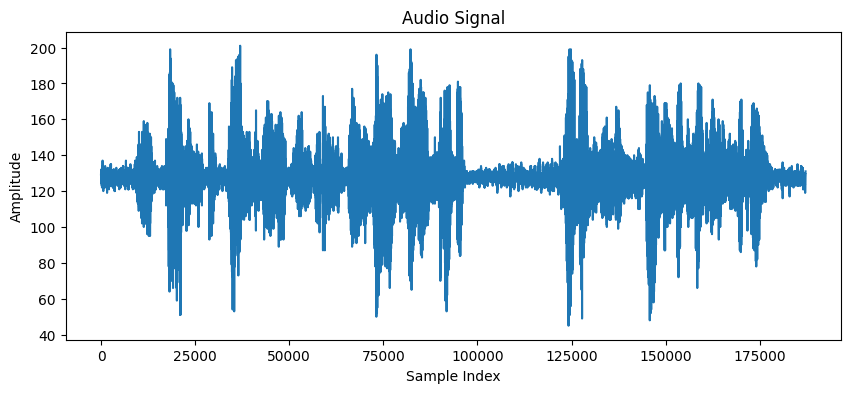

In [15]:
from scipy.io import wavfile
import matplotlib.pyplot as plt
file_path = "./why.wav"
sampling_rate, audio_signal = wavfile.read(file_path)
plt.figure(figsize=(10, 4))
plt.plot(audio_signal)
plt.title('Audio Signal')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()

## 17. 
Encode the audio signal using the binary ASCII fixed-length binary code. What is the appropriate number of bits? Justify.

In [16]:
# Given that the audio signal is quantized in a range 0-255 (8 bits) the appropiate number of bits to represent the audio is 8 bits
quantized_signal = np.interp(audio_signal, (audio_signal.min(), audio_signal.max()), (0, 255))
quantized_signal_int = np.round(quantized_signal).astype(np.uint8)
binary_ascii_encoded = [format(sample, '08b') for sample in quantized_signal_int]
##print(binary_ascii_encoded)

## 18. 
Simulate the channel effect on the binary audio signal. Then decode the audio signal.
Plot and play the decoded audio signal. What do you notice?

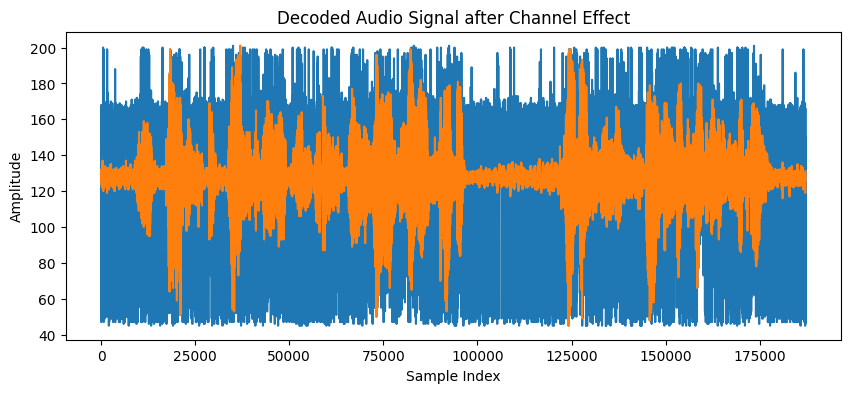

In [17]:
p_error = 0.01
fs = 16000

def simulate_bsc(encoded_signal, p_error):
    channel_output = []
    for bit_string in encoded_signal:
        flipped_bits = ''.join(['1' if (bit == '0' and np.random.rand() < p_error) else '0' if (bit == '1' and np.random.rand() < p_error) else bit for bit in bit_string])
        channel_output.append(flipped_bits)
    return channel_output

channel_affected_signal = simulate_bsc(binary_ascii_encoded, p_error)
channel_affected_signal_int = np.array([int(bits, 2) for bits in channel_affected_signal], dtype=np.uint8)
decoded_audio_signal_interp = np.interp(channel_affected_signal_int, (0, 255), (audio_signal.min(), audio_signal.max()))
decoded_audio_signal = np.round(decoded_audio_signal_interp).astype(np.uint8)

plt.figure(figsize=(10, 4))
plt.plot(decoded_audio_signal)
plt.plot(audio_signal)
plt.title('Decoded Audio Signal after Channel Effect')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()

wavfile.write('decoded_audio.wav', fs,decoded_audio_signal.astype(np.float32))

## 19. 
Instead of sending directly through the channel the binary audio signal, you will first
introduce some redundancy. To do that, implement a function that returns the
Hamming (7,4) code for a given sequence of binary symbols. Then, using your
function, encode the binary audio signal (from question 16).

In [18]:
def hamming_7_4(binary_sequence):
    """
    Correctly encode a sequence of 4-bit binary symbols using the Hamming (7,4) code.
    
    Args:
    binary_sequence: A list of strings, where each string is a 4-bit binary symbol.
    
    Returns:
    A list of strings, where each string is a 7-bit encoded binary symbol using the Hamming (7,4) code.
    """
    G= np.array([[1, 1, 0, 1],
                            [1, 0, 1, 1],
                            [1, 0, 0, 0],
                            [0, 1, 1, 1],
                            [0, 1, 0, 0],
                            [0, 0, 1, 0],
                            [0, 0, 0, 1]])
    
    encoded_sequence = []
    for symbol in binary_sequence:
        symbol_bits = np.array(list(symbol), dtype=int)
        encoded_symbol = np.dot(G, symbol_bits) % 2
        encoded_sequence.append(''.join(str(bit) for bit in encoded_symbol))
    return encoded_sequence

def encode_hamming74(binary_sequence_8bit):
    """
    Encodes 8-bit binary sequences using Hamming (7,4) code by splitting each 8-bit sequence
    into two 4-bit sequences, encoding each with Hamming (7,4), and then concatenating the results.
    
    Args:
    binary_sequence_8bit: A list of strings, where each string is an 8-bit binary sequence.
    
    Returns:
    A list of strings, where each string is a 14-bit sequence resulting from encoding the original 8 bits.
    """
    encoded_sequences = []
    
    for sequence in binary_sequence_8bit:
        first_half, second_half = sequence[:4], sequence[4:]
        
        encoded_first_half = hamming_7_4([first_half])[0]
        encoded_second_half = hamming_7_4([second_half])[0]
        
        encoded_sequence = encoded_first_half + encoded_second_half
        encoded_sequences.append(encoded_sequence)
    
    return encoded_sequences

encoded_sample_red = encode_hamming74(binary_ascii_encoded)


In [19]:
print(encoded_sample_red[:10])

['11100000011001', '11100000011001', '11100000110011', '11100001010101', '11100001010101', '11100001010101', '11100001010101', '11100000110011', '11100000110011', '11100000110011']


## 20. 
Simulate the channel effect on the binary audio signal with redundancy. Then decode
the binary audio signal. Listen to it and display the decoded audio signal. What do
you notice? Explain your decoding procedure.

In [20]:
channel_affected_signal_red = simulate_bsc(encoded_sample_red, p_error)

def hamming_7_4_decode(encoded_signal):
    """
    Decode and correct errors in a sequence of 7-bit binary symbols using the Hamming (7,4) code.
    
    Args:
    encoded_signal: A list of strings, where each string is a 7-bit encoded binary symbol.
    
    Returns:
    A list of strings, where each string is a 4-bit decoded binary symbol.
    """
    H = np.array([[1, 0, 1, 0, 1, 0, 1],
                  [0, 1, 1, 0, 0, 1, 1],
                  [0, 0, 0, 1, 1, 1, 1]])
    
    decoded_sequence = []
    for encoded_symbol in encoded_signal:
        symbol_bits = np.array(list(encoded_symbol), dtype=int)

        syndrome = np.dot(H, symbol_bits) % 2
        syndrome_value = syndrome.dot(1 << np.arange(syndrome.shape[-1] - 1, -1, -1))
        
        if syndrome_value > 0:  # If syndrome is not zero, correct the error
            symbol_bits[syndrome_value-1] ^= 1 
        
        # Extract the original 4 data bits (positions 2, 4, 5, 6 in the Hamming code)
        decoded_bits = symbol_bits[[2, 4, 5, 6]]
        decoded_sequence.append(''.join(str(bit) for bit in decoded_bits))
        
    return decoded_sequence

def decode_and_correct_hamming74(encoded_signal_14bit):
    """
    Decode and correct errors for 14-bit sequences that were encoded using Hamming (7,4) code twice.
    
    Args:
    encoded_signal_14bit: A list of 14-bit strings encoded with Hamming (7,4).
    
    Returns:
    A list of 8-bit binary strings decoded and corrected from the input signal.
    """
    decoded_sequences = []
    for sequence in encoded_signal_14bit:
        first_half = sequence[:7]
        second_half = sequence[7:]
        decoded_first_half = hamming_7_4_decode([first_half])[0]
        decoded_second_half = hamming_7_4_decode([second_half])[0]
        decoded_sequence = decoded_first_half + decoded_second_half
        decoded_sequences.append(decoded_sequence)
        
    return decoded_sequences


decoded_hamming_signal_14bit = decode_and_correct_hamming74(channel_affected_signal_red)
decoded_audio_samples = np.array([int(bits, 2) for bits in decoded_hamming_signal_14bit])
decoded_audio_red = np.interp(decoded_audio_samples, (0, 255), (audio_signal.min(), audio_signal.max()))
decoded_audio_red = np.round(decoded_audio_red).astype(np.uint8)


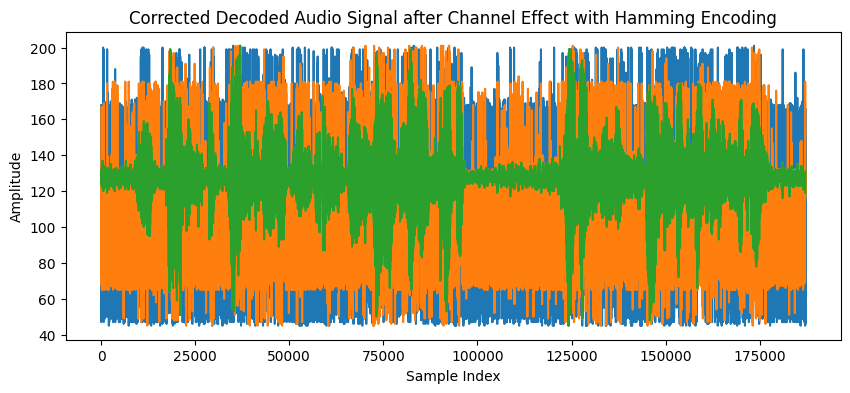

In [21]:
plt.figure(figsize=(10, 4))
plt.plot(decoded_audio_signal)
plt.plot(decoded_audio_red)
plt.plot(audio_signal)
#plt.plot(abs(decoded_audio_red - audio_signal))
#plt.plot(abs(decoded_audio_signal - audio_signal)[100000:100100])
#plt.plot(abs(decoded_audio_signal - decoded_audio_red)[0:25000])
plt.title('Corrected Decoded Audio Signal after Channel Effect with Hamming Encoding')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()

wavfile.write('decoded_audio_red.wav', fs,decoded_audio_red.astype(np.float32))